In [3]:
# MIT License

# Copyright (c) 2023 Nathan Zorndorf

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap

In [47]:
WIN = 100 
P_H = 0.4

class GamblersProblem:
    def __init__(self, p_h=P_H) -> None:
        self.p_h = p_h
        self.state = 50 
        self.state_space = list(range(0,WIN+1))
        self.state_value = np.zeros(WIN+1)
        return
    
    def reset(self):
        self.state = 50 
        return
    
    def action_space(self, state):
        return list(range(0, min(state, WIN-state)+1)) # caps action space to [0-50] and thus resulting state space to [0,100]

    
    def random_choice(self):
        choices = [1, -1]
        probabilities = [self.p_h, 1 - self.p_h]
        result = np.random.choice(choices, p=probabilities)
        return result
    
    def step(self, state, action):
        """
        Run one timestep of the selfironment's dynamics.

        Args:
            state (int): An int storing the number of dollars available to bet
            action (int): The number of dollars to bet 

        Returns:
            (Tuple[int, float]): The new state of the system, and its correspondent reward
        """
        # if state == terminal state, return associated reward 
        if state == 0:
            reward = 0
            next_state = state 
        elif state == WIN:
            reward = 1  
            next_state = state 
        else:
            reward = 0 
            next_state = action * self.random_choice() # sample from bernoulli distribution with probability p_h 

        return next_state, reward 

    def get_dynamics(self, state, action):
        dynamics = [] # list of tuples 
        # print(f'state={state}, action={action}')
        dynamics.append((self.p_h, int(state + action == WIN), self.state_value[state + action])) # if we win 
        dynamics.append((1-self.p_h, 0, self.state_value[state - action])) # if we lose 
        return dynamics
    
    def bellman_expectation(self, state, action, discount=1):
        expectation = 0
        for dynamics in self.get_dynamics(state, action):
            p, r, v = dynamics
            expectation += p * (r + discount * v)
        return expectation


    def policy_evaluation(self, steps=1, in_place=True):
        """
        Args:
            policy (numpy.array): a numpy 3-D numpy array, where the first two dimensions identify a state and the third dimension identifies the actions.
                                The array stores the probability of taking each action.
            steps (int): the number of iterations of the algorithm
            discount (float): discount factor for the bellman equations
            in_place (bool): if False, the value table is updated after all the new values have been calculated.
                if True the state [i, j] will new already new values for the states [< i, < j]
        """

        for k in range(steps):
            # cache old values if not in place
            values = self.state_value if in_place else np.empty_like(
                self.state_value)
            for state in self.state_space:
                # apply bellman expectation equation to each state
                value = self.bellman_expectation(state, self.policy[state])
                values[state] = value
            # set the new value table
            self.state_value = values
        return self.state_value
    
    def policy_improvement(self):
        '''
        Returns:
            (bool): True if policy no longer improves 
        '''
        policy_stable = True
        for state in self.state_space:
            old_action = self.policy[state]
            best_action = self.policy[state]
            best_value = -float("inf")
            for action in self.action_space(state):
                value = self.bellman_expectation(state, action)
                if value > best_value:
                    best_value = value 
                    best_action = action
            self.policy[state] = best_action # save best action to policy 
            policy_stable = False if best_action != old_action  else True 
        return policy_stable

    def policy_iteration(self):

        # starting policy is to bet to win 
        self.policy = [min(state, WIN-state) for state in self.state_space]
        policy_stable = False
        i = 0
        while(policy_stable == False):
            i += 1
            self.policy_evaluation(steps=10) # updates self.state_value internally
            policy_stable = self.policy_improvement() # updates self.policy internally
            if i in [0, 1, 2, 3, 32, 100]:
                print(f'i={i}')
                self.render([self.state_value], self.policy)
            if i == 100:
                raise ValueError("The policy did not converge. Check your inputs or look for bugs.")

    def render(self, values, policy):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        # plot values
        ax[0].set_ylabel("Values\nEstimates", rotation=0, labelpad=20)
        ax[0].set_xlabel("Capital")
        l = []
        for v in values:
            l.append(ax[0].plot(v,))
        # ax[0].legend(["sweep1", "sweep2", "sweep3","sweep32", "Final value function"])

        # plot policy
        ax[1].plot(policy, c="black")
        ax[1].set_ylabel("Final\nPolicy\n(stake)", rotation=0, labelpad=20)
        ax[1].set_xlabel("Capital")
        plt.show()
        return fig, ax

    # def bellman_expectation(self, state, action):
    #     discount = 1
    #     next_state, _ = self.step(state, action)
    #     expectation = 0
    #     for probs in self.get_transition_probs(state, action):


    #     sum(
    #         self.p_h * (int(state + action >= 100) + discount * self.value_function[state + action]),
    #         (1-self.p_h) * (0 + discount * self.value_function[state - action])

    #     )
    #     return 
    
    # def value_iteration(self, epsilon=0.01):
        
    #     # initialize value function 
    #     self.value_function = np.zeros(len(self.state_space))

    #     delta = 0 
    #     while(delta >= epsilon):   
    #         for state in self.state_space:
    #             old_v = self.value_function[state]
    #             self.value_function[state] = max(
    #                 [self.bellman_expectation(state, action) for action in self.action_space(state)]
    #             )

    


    

i=1


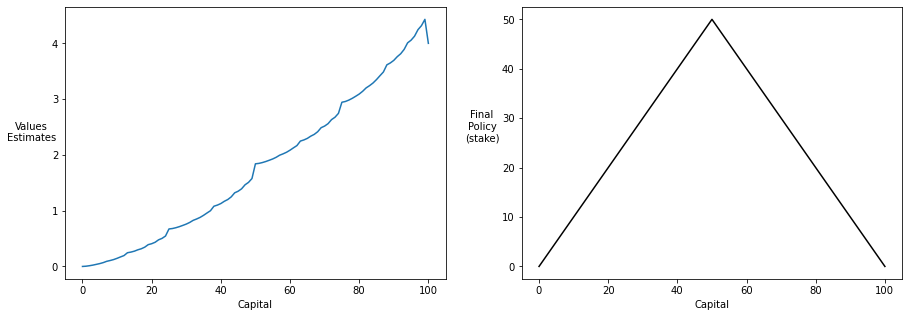

In [48]:
# initialize environment
env = GamblersProblem(p_h=0.4)

# # perform policy evaluation
# env.policy = [min(state, WIN-state) for state in env.state_space]
# for k in [0, 2, 3, 32, 100]:
#     env.policy_evaluation(steps=k)
#     print(f'k={k}')
#     env.render([env.state_value], env.policy)

# perform policy iteration
env.policy_iteration()